In [1]:
import math

import freq_statespace as fss
import matplotlib.pyplot as plt
import numpy as np
import optax
import optimistix as optx
from matplotlib import rcParams, gridspec
from matplotlib.lines import Line2D


# Load data
amplitude = 300  # [mV] either 100, 200, 300

u_train, y_train = np.load(f"data/u_{amplitude}mV_train.npy"), np.load(f"data/y_{amplitude}mV_train.npy")

N = u_train.shape[0]
nu, ny = u_train.shape[1], y_train.shape[1]

fs = 6400  # [Hz]
f_max = 3000  # [Hz] 
f_idx = np.arange(1, math.ceil(f_max / (fs / N)))  # frequency lines of interest (excludes DC)

data = fss.create_data_object(u_train, y_train, f_idx, fs)

In [2]:
# Fit Best Linear Approximation
nx = 28  # state dimension

solver = optx.BFGS(rtol=1e-3, atol=1e-5)
# solver = optx.OptaxMinimiser(optax.adam(learning_rate=1e-4), rtol=1e-3, atol=1e-5)

bla = fss.lin.subspace_id(data, nx)
bla = fss.lin.optimize(bla, data, solver=solver, max_iter=5000, print_every=100)

=============== Frequency-domain subspace identification ===============
BLA simulation error:
    output 1: 9.13%.
    output 2: 11.29%.
    output 3: 9.99%.

========================== BLA optimization  ===========================
Starting iterative optimization...
    Iter 1 | loss = 5.4358e+01
    Iter 101 | loss = 5.1744e+01
    Iter 201 | loss = 5.0498e+01
    Iter 301 | loss = 4.9197e+01
    Iter 401 | loss = 4.5949e+01
    Iter 501 | loss = 4.3436e+01
    Iter 601 | loss = 4.2586e+01
    Iter 701 | loss = 4.1452e+01
    Iter 801 | loss = 3.9899e+01
    Iter 901 | loss = 3.8526e+01
    Iter 1001 | loss = 3.6520e+01
    Iter 1101 | loss = 3.4723e+01
    Iter 1201 | loss = 3.3462e+01
    Iter 1301 | loss = 3.2493e+01
    Iter 1401 | loss = 3.1810e+01
    Iter 1501 | loss = 3.1010e+01
    Iter 1601 | loss = 3.0333e+01
    Iter 1701 | loss = 2.9618e+01
    Iter 1801 | loss = 2.8823e+01
    Iter 1901 | loss = 2.8048e+01
    Iter 2001 | loss = 2.7058e+01
    Iter 2101 | loss = 2.6191e

In [3]:
# --- Evaluate BLA on test data ---
u_test, y_test = np.load(f"data/u_{amplitude}mV_test.npy"), np.load(f"data/y_{amplitude}mV_test.npy")

y_test_bla = bla.simulate(u_test, offset=1000)[0]

# Compute averaged NRMSE per output channel
error = y_test - y_test_bla
mse = np.mean(error**2, axis=(0, 2, 3))
norm = np.mean(y_test**2, axis=(0, 2, 3))
nrmse = 100 * np.sqrt(mse / norm) 

print(f"BLA test error at {amplitude}mV")
for i, val in enumerate(nrmse):
    print(f"    Output {i+1}: {val:.2f}%")


BLA test error at 300mV
    Output 1: 4.53%
    Output 2: 7.02%
    Output 3: 5.37%


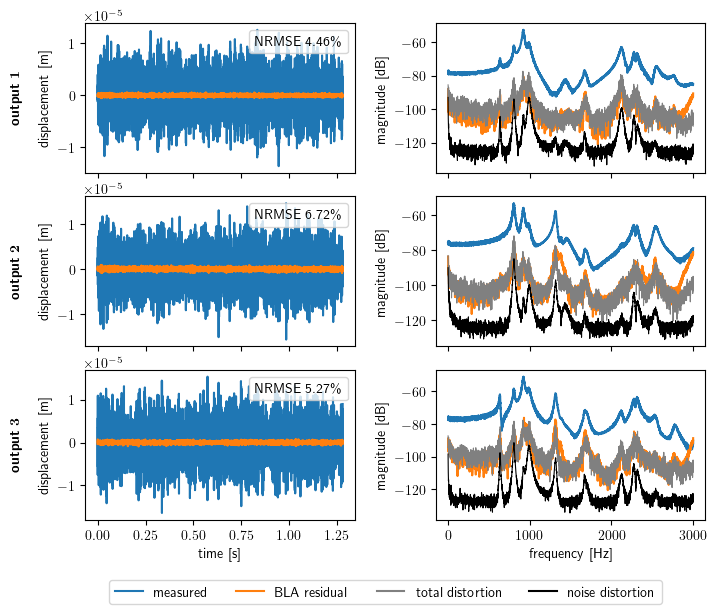

In [4]:
# --- Visualize test results ---

# Enable LaTeX rendering for text
rcParams['text.usetex'] = True

# Figure and layout setup
fig = plt.figure(figsize=(8, 7))
gs = gridspec.GridSpec(4, 2, height_ratios=[2, 2, 2, .25], hspace=0.2, wspace=0.3)

# Compute NRMSE per output
NRMSE_list = 100 * np.sqrt(np.mean(error**2, axis=0) / np.mean(y_test**2, axis=0))

# Frequency-domain quantities
Y_test = np.fft.rfft(y_test, axis=0)[f_idx, :]
Y_error = np.fft.rfft(error, axis=0)[f_idx, :]
Y_test_abs = np.mean(np.abs(Y_test), axis=(2, 3))
Y_error_abs = np.mean(np.abs(Y_error), axis=(2, 3))

# Distortion levels
U_abs = np.abs(data.freq.U[f_idx]).mean(axis=2, keepdims=True)
std_tot = data.norm.y_std * np.sqrt(data.freq.G_bla.var_tot) @ U_abs
std_noise = data.norm.y_std * np.sqrt(data.freq.G_bla.var_noise) @ U_abs

axs_mag = []
for i in range(3):
    # --- Time-domain plots ---
    ax_time = fig.add_subplot(gs[i, 0])
    ax_time.plot(data.time.t, y_test[:, i, 0, 0])
    ax_time.plot(data.time.t, error[:, i, 0, 0])
    if i < 2:
        ax_time.set_xticklabels([])
    else:
        ax_time.set_xlabel("time [s]")
    ax_time.set_ylabel(rf"$\textbf{{output }} \mathbf{{{i+1}}}$" + "\n\n" + r"displacement [m]")

    # NRMSE legend
    nrmse_text = Line2D([], [], linestyle='None', marker='', 
                        label=f'NRMSE {NRMSE_list[i, 0, 0]:.2f}\%')
    ax_time.legend(handles=[nrmse_text], loc='upper right', frameon=True, 
                   handlelength=0, handletextpad=0)

    # --- Frequency-domain plots ---
    ax_mag = fig.add_subplot(gs[i, 1])
    ax_mag.plot(data.freq.f[data.freq.f_idx], 20*np.log10(Y_test_abs[:, i]))
    ax_mag.plot(data.freq.f[data.freq.f_idx], 20*np.log10(Y_error_abs[:, i]))
    ax_mag.plot(data.freq.f[data.freq.f_idx], 20*np.log10(std_tot[:, i]), 
                color='grey', linewidth=0.8)
    ax_mag.plot(data.freq.f[data.freq.f_idx], 20*np.log10(std_noise[:, i]), 
                color='black', linewidth=0.8)
    if i < 2:
        ax_mag.set_xticklabels([])
    else:
        ax_mag.set_xlabel("frequency [Hz]")
    ax_mag.set_ylabel("magnitude [dB]")
    axs_mag.append(ax_mag)

# Legend and layout
ax_legend = fig.add_subplot(gs[3, :])
ax_legend.axis('off')
fig.align_ylabels(axs_mag)

main_legend = [
    Line2D([0], [0], label='measured'),
    Line2D([0], [0], color='C1', label='BLA residual'),
    Line2D([0], [0], color='grey', label='total distortion'),
    Line2D([0], [0], color='black', label='noise distortion'),
]

fig.legend(handles=main_legend, loc='lower center', ncol=4, frameon=True,
           borderaxespad=0.0, bbox_to_anchor=(0.5, 0.05))

plt.show()

# The total distortion level combines nonlinear and noise distortions. The fact that the
# BLA residual is close to this level shows that the BLA captures nearly all behaviour a
# linear model can. Reducing the gap between the model residual and noise distortion
# level would require introducing a nonlinear model.